# 내 거친 생각과 불안한 눈빛과 그걸 지켜보는 카메라앱

## ML Coarse-to-Fine 전략과 Active Learning 기초

- 머신러닝 서비스를 만들때 가장 중요한 것은 뭘까요? 가장 중요한 것 하나만 꼽으라고 한다면 저는 데이터라고 말하고 싶습니다.

- 그러나 우리가 만들고자 하는 머신러닝 서비스에 꼭 알맞는 데이터셋을 늘 구할 수 있는 것은 아닙니다. 오히려 그런 이상적인 경우는 극히 드물다고 봐야겠지요. 

- 현실 문제에 부딪혔을 때 우리는 모델을 어떻게 만들거냐 보다 훨씬 많은 시간을 데이터를 어떻게 수집, 가공할 것이냐의 문제로 고민하게 될 것입니다. 언제나 그렇듯 확보한 데이터의 갯수는 턱없이 부족하고, 이를 메꾸기 위한 예산은 확보되어 있지 않으며, 서비스 딜리버리 타임은 얼마 남지 않은 현실을 우리는 어떻게 헤쳐 나갈수 있을까요?

- 그래서 이번 시간에는 머신러닝 엔지니어가 늘 고민해 오는 문제, 바로 데이터를 효율적으로 모으는 방법에 대해 이야기하겠습니다.

## 학습 목표입니다.

    1. 데이터를 직접 모아보기
    2. 딥러닝이 아닌 머신러닝 방법을 사용하기
    3. Keypoints Regressor 제작하기
    4. 라벨링 툴 다뤄보기


# 카메라앱에 당황한 표정 효과를 추가하려면?
- 만화를 보면 캐릭터가 당황할 때 나오는 표정이 재미있지 않나요? 이 효과를 카메라앱으로 구현하려면 어떻게 해야 할까요?

- 이미 짐작하고 계실 것 같습니다. 우선 눈을 찾아야 합니다. 기본적으로 랜드마크(landmark)를 이용해 눈의 위치를 찾는 방법은 아마 알고 계시리라 생각합니다. 하지만 일반적인 랜드마크는 눈이 바라보고 있는 방향까지는 포함하고 있지 않습니다.

- 아래 사진처럼 시선의 방향이 왼쪽으로 향하고 있다는 정보를 이용하려 합니다. 어떻게 해결할 수 있을까요? ***눈동자의 위치*** 를 알 수 있다면 더 섬세한 표현이 가능할 것을 예상할 수 있습니다.

## 눈동자를 찾는 방법

- 그러면 눈동자를 쉽게 찾는 방법이 있을까요? dlib과 같은 오픈소스 라이브러리는 눈의 외곽선 위치만 찾아줄 뿐 시선을 나타내는 눈동자는 찾아주지 않습니다. 우리는 눈의 외곽선 정보를 사용해 눈을 찾아내고 그 내부에서 눈동자를 검출해야 합니다.

- 이 데이터셋은 분명 눈동자 검출과 관련이 있는 데이터이지만 우리가 목표로 하는 촬영 환경과 많이 다릅니다. 우리는 핸드폰 카메라 기반의 팔 너비 정도의 촬영 환경을 가지는 반면 공개된 데이터셋은 AR 기기를 위한 10cm 이내의 근거리 촬영 환경입니다.

- 실제 서비스를 만들 때에도 우리가 만들고 싶은 환경에 꼭 맞는 데이터셋을 찾기는 매우 어렵습니다. 따라서 머신러닝 개발자는 공개된 데이터와 모델이 모두 없을 때 문제를 접근하는 방법에 대해 고민하고, 해결책을 찾을 수 있어야 합니다.

- 딥러닝 기반 방법을 적용하려면 아주 많은 데이터가 필요합니다. 자본이 풍부한 상황이라면 데이터와 주변 환경을 구매하는 방법으로 해결할 수 있습니다. 하지만 처음 시도하는 업무에 대규모 자본을 투자하기란 현실적으로 굉장히 어렵습니다. (성공할 수 있을지, 성과를 낼 수 있을지 확신하기 어려우니까요.) 따라서 초기 컨셉 증명 단계에서는 소규모의 자본과 인력으로 프로토타입을 만들어야하는데 이 때 딥러닝을 적용하기가 쉽지 않습니다.

- ***기존 머신러닝 방법을 적절히 이용하는 방법***과 ***잘 가공된 어노테이션(annotation) 도구***를 만들 수 있다면 바로 딥러닝 방법을 적용하는 것보다 빠르게 문제를 해결해 나갈 수 있습니다.


### 학습 내용

    1. 기존 머신러닝 방법을 적용한 눈동자 검출 모듈을 만드는 방법에 대해 설명합니다.
    2. 딥러닝 방법을 이용한 눈동자 검출 모듈을 제작하고
    3. 앞에서 만들어진 데이터와 함께 높은 품질의 라벨을 얻을 수 있는 라벨링 툴(labeling tool) 대해 설명합니다.
    4. 마지막으로 앞의 과정을 어떻게 효율적인 순서로 진행할 수 있는지 논의하겠습니다.

# 대량의 Coarse Point Label 모아보기 (1) 도메인의 특징을 파악하자

- 딥러닝을 적용하지 않고 머신러닝 방법을 이용한다는 말은 곧 handcraft feature(사람이 정의한 특징)를 사용해야 한다는 말과 같습니다. 이때 모델이 사용할 특징을 정의하기 위해서는 해당 분야에 대한 이해가 필요합니다. 즉, 도메인 전문가가 좋은 모델을 만들 확률이 높습니다.

- 이 방법이 어떻게 적용될 수 있고 왜 필요한지 예시를 들어볼까 합니다.

- 저는 2018년에 알츠하이머 치매 진단 보조 솔루션을 만들었습니다. MRI를 촬영한 후 뇌 조직을 분석해서 알츠하이머 환자와 정상군의 분포를 파악하는 업무를 진행했습니다. 다양한 치매의 종류를 접할 수 있었고 그 중 한 사례를 말씀드리려 합니다.

- 혈관성 치매(Vascular Dementia) 는 뇌혈관 문제로 뇌조직이 손상을 입게 되어 발생하는 치매입니다. 치매는 현재 치료법이 없기 때문에 발병을 미리 예측하고 대비해서 진행을 늦추는 방법이 최선입니다. 그만큼 조기 진단으로 병의 분류와 원인을 찾는 것이 중요합니다. 다른 알츠하이머와 마찬가지로 이 경우도 MRI 이미지를 통해 진단을 도울 수 있습니다. MRI에는 T1w, T2w, FLAIR 등 다양한 촬영 방식(protocol)이 있습니다. FLAIR 이미지를 한 장 살펴보겠습니다.

- 처음보면 어디가 정상이고 어디가 문제인지 전혀 파악할 수 없습니다. 이 이미지에서는 "회백질"이 어디인지, "백질"이 어디인지 구분이 잘 되지 않죠(둘은 뇌의 각 부분의 이름입니다). 사실 FLAIR 이미지에서는 백질과 회백질을 구분하기 어려운 대신 뇌척수액과 같은 물은 비교적 구분하기 쉽습니다. (What Does Hyperintensity Mean On An Mri Report?)

- 아래 그림을 보겠습니다. 빨간색 영역과 같이 뇌척수액 부분은 주변보다 흰 값으로 나타나게 됩니다. 뇌혈관에 문제가 생기게 되면 피 등의 액체가 백질에 스며들게 되고 뇌조직에 문제가 생길 수 있습니다. 백질이 보다 밝은 값으로 나타난다고 해서 WMH(White Matter Hyperintensity)라고 합니다. WMH가 있다고 반드시 문제가 생기는 것은 아니지만 문제가 생긴 환자 중에서 많은 사례가 WMH를 가지고 있습니다.

- 그래서 뇌의학 선생님들은 WMH를 찾는 것을 중요하게 생각하고 있습니다. 저도 자동으로 찾아야 했는데 문제는 라벨이 마땅하지 않았습니다. (물론 지금은 오픈데이터가 조금씩 생기고 있습니다.) 세그멘테이션(segmentation)은 라벨링(labeing)이 어렵기 때문에 초기에는 딥러닝을 사용하지 않는 방법을 사용해야 했습니다.

- 이 문제는 생각해보면 아주 쉽게 초기 모델(baseline)을 만들어볼 수 있습니다. WMH의 뜻을 다시 살펴볼까요? WM Hyperintensity, 즉 이름처럼 하얗게 표시되는 부분은 높은 픽셀 값을 가지고 있습니다. 그러므로 255 범위 내에서 200 이상의 값을 가지는 픽셀들만 찾아내면 간단한 초기 모델을 만들 수 있습니다.

- 이렇게 초기 모델을 만들고 이 데이터를 바탕으로 딥러닝 모델을 학습시켜 나가면 좋은 성과를 얻을 수 있습니다.

- 이렇게 근사적인(coarse) 데이터셋을 간단히 만들고, 이를 이용해 초기 모델을 만든 후 그 모델을 더욱 정교하게 훈련시켜가는 전략을 ***ML Coarse-to-Fine 전략***이라고 합니다.

- 이 이야기에서 중요한 점은

    1. 풀고 싶은 도메인의 지식을 익힐 것 : 혈관성 치매와 WMH, MRI 에서 어떤 패턴을 보이는지
    2. 딥러닝이 아닌 방법을 적용할 수 있는 능력 : Image threshold 등 영상처리 기법
    3. 등을 생각하고 적용할 수 있어야 한다는 것입니다.

# 대량의 Coarse Point Label 모아보기 (2) 가우시안 블러

## 가우시안 블러

- 다시 우리 문제로 돌아와서, "눈동자에는 어떤 특징이 있을까?"를 고민해 봅시다.

- WMH와 반대로 눈동자는 어둡습니다. 어두운 부분의 중간을 찾으면 될 것 같지 않나요?

- 네 그렇습니다. 저는 그렇게 접근했습니다. (물론 더 좋은 방법이 있다는 사실을 늘 염두에 두어야 합니다.)

- 랜드마크(landmark)를 이용해서 눈을 crop 하고 눈에서 가장 어두운 부분의 중심을 찾습니다. 눈동자에 빛이 반사되는 경우가 있는데 노이즈(noise) 성분을 없애기 위해 (대체적으로 눈동자가 어두운 경향을 따르기 위해) 가우시안 블러(gaussian blur)를 적용했습니다. (처음에 제 눈을 가지고 그대로 만들었을 때는 문제가 없었는데.. 제가 눈이 작은 탓이겠죠.. 아래에 제 눈동자가 나옵니다.)

- 가우시안 블러는 어떤 종류의 필터(filter)인가요? : 저역 통과 필터(Low pass filter)로 고주파 신호를 감쇄시키는 필터입니다. 현재 픽셀값과 주변 픽셀값의 가중 평균을 사용해 현재 픽셀을 대체합니다.

- 가우시안 블러는 어떤 숫자들로 이루어져 있나요? 예시 3x3 행렬을 써봅시다.: [[1, 2, 1], [2, 3, 2], [1, 2, 1]] 이런 식으로 가중치 행렬을 이용해 구현할 수 있습니다.

- 블러 후 흑백을 반전시켰습니다. 여기서 가장 높은 값을 갖는 픽셀을 고르면 아래 그림처럼 눈의 위치를 찾을 수 있습니다.

- '가장 높은 값'의 기준은 여러 방향으로 정의할 수 있습니다. 2D 이미지 상에서 바로  위치를 추정하는 방법()이 있을 수 있고 위 그림에서 오른쪽과 아래 부분에 보이듯이 1차원으로 누적하는 방법이 있습니다.

- 위 2차원 이미지에서 눈의 중심 부분 근처 픽셀은 거의 모두 255로 최대값을 나타냅니다. 따라서 눈동자를 특정하기가 어려운데요, 가우시안 블러를 적용하면 눈동자 중심을 평균으로 하는 가우시안 분포를 볼 수 있습니다. 물론 최대값 255로 truncate 되어 있고 눈동자만 밝은 것이 아니기 때문에 mixture density처럼 나타나집니다.

- 이때 1차원으로 누적해서 표현하면 255로 truncated 되는 문제와 주변 노이즈에 조금 더 강건하게 대처할 수 있습니다.

# 대량의 Coarse Point Label 모아보기 (3) 구현: 눈 이미지 얻기

- 이론적인 부분을 코드로 나타내 봅시다. 사용할 라이브러리는 아래와 같습니다.

In [8]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib

(2048, 1536, 3)


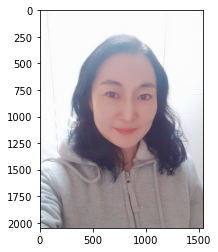

In [9]:
import os
img_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/images/Yesica.jpg'
img = cv2.imread(img_path)
print (img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

- 지금까지 해온 방법대로 얼굴과 랜드마크를 검출합니다.

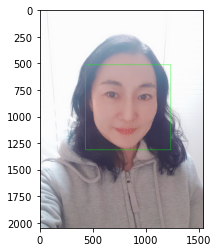

In [10]:
img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
dlib_model_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(dlib_model_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

plt.imshow(img_rgb)
plt.show()

- 랜드마크를 이용해서 눈 위치만 crop합니다.

- dlib의 랜드마크 자료형은 68개의 점을 가지고 있습니다.

- 왼쪽 눈과 오른쪽 눈의 점 위치는 몇 번째 점인가요?: 오른쪽: 36-41 (6), 왼쪽: 42-47 (6) → 0번째부터 시작

In [17]:
def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()
    
    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl
    
    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6
    
    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

- landmark의 오차로 눈을 검출하기 어려울 수 있기 때문에 적당한 margin 값을 설정했습니다.

- 실제로 눈을 crop해 보겠습니다.

In [21]:
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

(60, 128, 3)


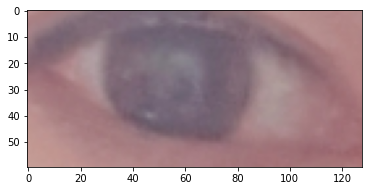

In [22]:
# 왼쪽 눈 출력
print (img_left_eye.shape)
plt.imshow(cv2.cvtColor(img_left_eye, cv2.COLOR_BGR2RGB))
plt.show()

(55, 123, 3)


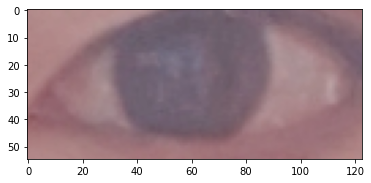

In [23]:
# 오른쪽 눈 출력
print (img_right_eye.shape)
plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
plt.show()

- HD 이미지 크기에서 47 x 26 정도의 눈을 얻을 수 있었습니다.

# 대량의 Coarse Point Label 모아보기 (4) 구현: 눈동자 찾기

- 눈 중심을 찾는 함수를 만들겠습니다. 아래 코드의 주석과 설명을 함께 봐주세요.

- 먼저, 눈 이미지를 low pass filter를 이용해서 smoothing 합니다. 저는 bilateralFilter를 이용했습니다.

- 다음으로 1차원 값으로 누적시킨 후 y 축 기준으로 최대값을 찾아서 center_y 좌표를 먼저 얻어냅니다. (y 축은 x 축에 비해 상대적으로 변화가 적기 때문에 간단하게 구현할 수 있습니다)

- x축은 1차원 max point를 기준으로 mean shift를 수행합니다. 양 끝단에 수렴하는 예외를 처리한 후 결과를 출력합니다.

In [24]:
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]

    # smoothing
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1
    
    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1
    
    return [center_x, center_y]

- 왼쪽, 오른쪽 두 눈 이미지에 대해 위 함수들을 수행합니다.

In [25]:
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

- 결과를 뽑아보면 아래와 같은 좌표를 얻을 수 있습니다.

In [26]:
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

(70, 11) (55, 25) (60, 128) (55, 123)


- 이미지로 뽑아볼까요? 오른쪽 눈을 보겠습니다.

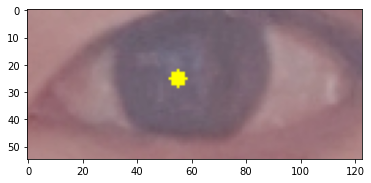

In [27]:
show = img_right_eye.copy()
    
show = cv2.circle(show, (right_center_x, right_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

- 네. 꽤 잘 나온 것을 볼 수가 있습니다.

- 왼쪽 눈도 확인해 보겠습니다.

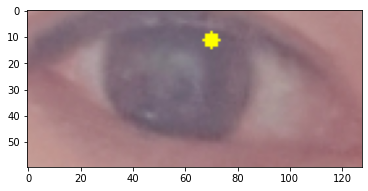

In [28]:
show = img_left_eye.copy()
    
show = cv2.circle(show, (left_center_x, left_center_y), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

- 눈동자를 찾긴 했지만 정확한 눈동자의 중심은 아니어서 조금 아쉽습니다. 다른 방법을 적용해 볼 수 있을까요? 아래 링크를 참고해봅시다.
- Mean shift는 클러스터링 알고리즘으로 사용되고 있지만 다른 목적으로도 사용 가능합니다. 눈동자 검출의 목적에 맞게 사용할 수 있을까요? 
    - Mean shift는 local maxima를 찾아가는 알고리즘이므로 눈동자를 local한 maxima로 가정하면 적용할 수 있다.
    
- 기존의 머신러닝 방법들은 도메인 지식을 적용해서 간단하고 빠르게 구현할 수 있는 장점이 있습니다. 반면 일정 수준 이상의 성능을 만족하기 어렵습니다. 
- 따라서 ***조금 모자란 성능으로 대량의 coarse한 라벨을 수집한 뒤, 딥러닝 모델을 개선해 나가는 학습 전략을 사용해야 합니다.***

# 키포인트 검출 딥러닝 모델 만들기

- 이제 더 나은 성능을 위해 딥러닝 모델을 만드는 것을 고려해야 합니다. 앞에서는 도메인 지식을 활용해서 수작업으로 특성들을(hand-crafted features) 만들었다면 ***이제부터는 도메인 지식 없이 뉴럴넷이 특징을 자동으로 뽑을 수 있도록 설계합니다.***

- 지금까지 우리는 VGG, Resnet 등 기본(base) 모델을 이미지 분류 문제를 위해 사용해 왔습니다. 주로 수십 개 이내의 클래스 중 하나를 찾는 문제에 적용했는데 이 모델을 우리의 목표인 눈동자로 변형해 주어야 합니다.

- 이미지 분류 모델은 이미지를 CNN에 입력해서 최종적으로 해당 클래스의 인덱스를 찾아냅니다. 즉, 모델의 출력은 클래스를 나타내는 단일 idx 값(또는 one-hot vector)이 됩니다. 눈동자 위치를 찾기 위해서 아래와 같은 구조로 모델을 변경해야 합니다.

- 가장 먼저, 출력의 개수가 변경됩니다. 이미지 분류 문제에서는 소프트맥스(softmax)를 통과해 1개의 클래스 인덱스를 출력했지만 눈동자 중심 위치인 x, y 좌표를 출력해야 합니다. 이 때 값은 분류 모델의 정수형 불연속 값이 아닌 연속형 값이어야 합니다. 이런 문제를 회귀(regression) 문제라고 합니다.

- 각 태스크의 출력 특징

    - Image Classification : argmax(softmax)의 불연속 정수형 값
    - Image Localization(regression) : 연속형 실수 값

- 소프트맥스 - 크로스 엔트로피(cross-entropy) 방법은 이미지 클래스를 구분하기 위해 사용하는 가장 대표적인 손실 함수입니다. 회귀에서는 어떨까요? 여러 개의 값이 연속형 실수로 출력되어야 하기 때문에 MSE와 같은 손실 함수를 고려할 수 있습니다.

- 이제 만든 모델을 학습시키면 됩니다. 이론적으로는 학습시키면 됩니다. 하지만 실전은 항상 더 어렵습니다. 내 니즈에 꼭 맞는 커스텀 태스크의 경우는 데이터가 대부분 부족합니다. 오늘 강의에서도 높은 퀄리티의 눈동자 라벨을 얻기가 꽤 어렵다는 사실을 느껴오셨을 것입니다.

- 이런 경우에 접근할 수 있는 방법은 미리 학습된 가중치(weight)를 가지고 와서 fine tuning 하는 것입니다. 가져온 가중치가 학습된(pretrained) 태스크가 나의 태스크와 같은 도메인이면 더 좋겠지만 아니어도 효과는 있습니다. 그래서 보통은 이미지넷(ImageNet)이나 COCO 데이터셋으로 학습한 모델 가중치를 가져와서 fine tuning 합니다.

- 코드로 표현하면 어떻게 해야 할까요?

    - 기본 ResNet 모델을 구현하고
    - ImageNet 데이터셋으로 pretraining 을 열심히 한 후,
    - ResNet의 fully connected layer 를 수정하고 회귀 손실 함수를 구현해서
    - 눈동자 위치를 학습시킵니다.

- 1 ~ 3번까지 직접 작업하려면 ImageNet 훈련이 매우 오래 걸리기 때문에 꽤 번거롭습니다.

- 하지만 텐서플로우에서 tensorflow_hub 를 제공하기 때문에 ImageNet으로 학습된 모델을 가지고 오는 방법을 제공합니다.

- (주의) tensorflowhub 와 tensorflow-gpu 사이의 버전문제가 있을 수 있습니다. 이번 실습에서는 tensorflow-gpu==2.2.0, tensorflowhub==0.10.0 을 권장합니다.

In [30]:
!pip install tensorflow_hub # 설치되어 있지 않은 경우 주석 해제
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

- tensorflow_hub 를 import 합니다. hub 에는 VGG 네트워크 외에도 많은 모델을 제공하고 있습니다. 아래 링크를 참고해주세요.

- 많은 모델들이 사용 설명과 함께 제공됩니다.

- 그 중 저는 ResNet-50을 사용하기로 했습니다. 모델이 기억나지 않는다면 아래 링크를 참고해주세요.

- Resnet에서 사용하고 있는 residual block의 종류는 몇 가지인가요?
    - 1) 3x3 conv 2개의 일반 residual block
    - 2) 1x1 conv를 이용한 bottleneck 구조
- ResNet이 VGG보다 성능이 좋은 이유는 무엇일까요?
    - skip connection을 통해 불필요한 파라미터를 줄일 수 있는 효과를 얻음. 
    - 불필요한 파라미터인지도 직접 학습할 수 있는 end-to-end 구조와 skip connection, 3x3 conv 의 앙상블 효과가 성능에 긍정적인 영향을 미침
- 마침 tensorflow_hub 에서 적절한 ResNet-50 모델을 구현해 제공하고 있네요!
    - 모델은 resnet50, 학습된 dataset 은 ImageNet 이라는 정보를 확인할 수 있습니다.
- 미리 훈련된 모델을 가지고 오는 것은 아주 유용합니다. 하지만 몇 가지 사항을 반드시 고려해야 이후에 발생할 문제를 줄일 수 있습니다. 모델 설명을 보면서 어떤 점을 고려해야 할지 찾아봅시다.
    - Fine tuning을 할 때는 모델의 입력을 특히 주의해야 합니다. 입력 크기의 차이가 많은 경우 pooling 후 크기가 유효하지 않을 수 있어서 모델이 아예 동작하지 않을 수 있습니다. 모델 설명 페이지에서는 이 문장을 반드시 찾아야합니다. 우리의 경우 다음과 같습니다.
    - The expected size of the input images is height x width = 224 x 224 pixels by default, but other input sizes are possible (within limits).
- TensorFlow Hub 모델을 코드로 불러와 봅시다. tensorflow_hub 에서 ResNet의 특성 추출기 부분을 백본으로 사용합니다.

In [31]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(80,120,3))

- 좌표를 학습할 수 있도록 Dense 레이어를 추가합니다.

In [33]:
num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

- 모델이 어떻게 생겼는지 확인해 봅시다.

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


# 라벨링 툴 (1) 소개

- 이전 단계에서 coarse label로 모델을 어느 정도 수준까지 만들었습니다. 이제 ***fine label***을 얻어서 모델을 향상시켜야 할 때입니다. 양질의 라벨을 빠르게 얻기 위해선 ***어노테이션 툴(annotation tool) 또는 라벨링 툴(labeling tool)*** 을 사용해야 합니다.

- 잘 알려진 비전 태스크(image classification, object detection, semantic segmentation)는 공개된 어노테이션 도구가 많습니다.

- OpenCV의 CVAT 은 이미지 검출(object detection) 등에 이용할 수 있고 무료로 공개되어 있습니다.
    - OpenCV/cvat (https://github.com/openvinotoolkit/cvat)

- imglab 이라는 툴도 공개되어 있는데요, COCO 데이터셋 형태로 저장할 수 있고 키포인트 라벨링(keypoints labeling)도 할 수 있습니다.
    - COCO Dataset (https://cocodataset.org/#home)
    - NaturalIntelligence/imglab (https://github.com/NaturalIntelligence/imglab)

- 무료로 공개된 이미지 어노테이션 툴을 2가지 더 찾아서 작성해봅시다.
    - labelimg (https://github.com/tzutalin/labelImg)
    - labelme (https://github.com/wkentaro/labelme) 등

- 여러 어노테이션 도구들을 살펴보면 몇 가지 특징을 알 수 있습니다.

    - QT 등의 GUI 프레임워크를 이용하는 방법과 웹 기반 방법으로 나누어집니다.
    - 단축키와 라벨 저장 포맷 등 편의성을 향상시킬 수 있는 기능을 적극적으로 적용합니다.

- 높은 편의성을 앞세워서 공개하고 있지만 막상 사용해보면 우리가 원하는 태스크에 딱 맞지 않는 경우가 대부분 입니다. (3D 환경에서 세그멘테이션 해야 하는 일 등)

- 우리는 눈동자의 위치를 선택할 수 있는 도구가 필요합니다. imglab에는 키포인트(keypoint) 도구가 있기 때문에 사용해 볼 수는 있습니다. 하지만 문제는 COCO 데이터셋에서 라벨링한 스타일을 지켜야하기 때문에 17개의 키포인트를 정해야 하는 규칙이 있다는 점입니다. 우리는 눈동자 1개를 찍거나 양 눈 옆 2개의 점이 필요한데 이 조건에 꼭 맞는 라벨링 도구를 만나기는 쉽지 않습니다.

- 결국 일을 하다 보면 입맛에 맞는 도구를 직접 만들게 됩니다. 마침 적절한 제작기가 있으니 한번 읽어봅시다.
    - Linewalks - Data tech company for healthcare system (https://blog.linewalks.com/archives/6240)

- Linewalks에서는 어떤 영역(도메인) 문제를 해결하기 위해 어노테이션 툴을 제작했나요?
    - 의료 분야(안저영상)의 진단 보조시스템

- 저자는 어노테이션 툴을 만들기 위해 어떤 프레임워크를 사용했나요? 해당 프레임워크의 장점은 무엇인가요?
    - electron, 웹 개발자가 익숙한 언어로 바로 사용할 수 있기 때문에 학습 장벽이 낮음. cross platform이다.
    
- 문제는 저를 포함한 우리 초보자들은 웹 프레임워크나 GUI 프로그래밍에 익숙하지 않다는 점입니다. 라벨링 툴을 제작하려 생각하다보면 QT, MFC, 심지어 HTML/CSS/JavaScript를 익히고 어플리케이션 수준까지 만들 고민을 하는 상황을 맞이하게 됩니다. 머신러닝 엔지니어 입장에서 배보다 배꼽이 더 큰 상황이 되므로 상당한 부담을 느낄 수 있습니다.

- 따라서 가장 간단하고 효율적인 형태로 라벨링 툴을 제작해야 합니다. 저는 라벨링을 할 때 두 단계로 라벨링을 하고 있습니다.
    - 기존에 만들어진 라벨이 잘 예측하는지 True / False 분류
    - 해당 태스크의 어노테이션 툴 (우리의 경우 키포인트 어노테이션)

- 오늘 다룰 눈동자 검출은 1, 2번 모두 OpenCV만을 이용해서 아주 간단하게 만들 수 있습니다. 이번 시간에는 1번을 만들어 보겠습니다.

# 라벨링 툴 (2) 직접 제작하기

- 파이썬과 OpenCV만을 이용해서 아래와 같이 터미널 명령으로 아주 쉽게 실행 할 수 있는 어노테이션 도구를 만들겠습니다. 파일명은 my_labeler_1st.py로 하겠습니다.

- alpha 값은 알파 블렌딩(alpha-blending) 기법의 블렌딩 상수입니다.

- alpha blending 의 수식은 어떻게 되나요?: pixelvalue = alpha * input + (1 - alpha) * mask

- 이미지, 예상 라벨의 경로에 문제가 없는지 체크합니다.

- img_path 가 디렉토리로 입력되는 경우(os.path.isdir(config.img_path)), 디렉토리 내에 있는 이미지 전체 인덱스를 찾고 첫 번째 이미지를 읽습니다.

- 마스크로는, mask_path 디렉토리에서 읽어진 이미지와 같은 이름을 갖는 라벨 이미지를 가지고 올 예정입니다.

- 다음 이미지로 넘어가는 함수입니다. 키워드로 입력된 pos 변수를 이용해서 순서(idx)를 하나씩 조절합니다.

- idx 가 리스트 크기 이상으로 될 때 순서를 다시 0으로 조정합니다.

- 메인이 되는 함수를 만들겠습니다. img_list 의 이미지들을 하나씩 읽으면서 json_file에 라벨을 하나씩 입력합니다.

- 현재 이미지 순서를 알 수 있도록 출력하고 p 와 f 를 입력할 때 dict_label 에 정답을 입력하도록 만듭니다. s 를 누르면 json 파일 형태로 저장합니다.

- 가볍고 빠른 라벨링 툴을 만들었습니다. 머신러닝 업무에서 데이터가 가장 중요한 만큼, 필요하다면 라벨링 툴을 만들어 직접 데이터를 수집할 수 있어야 합니다. 위와 같은 만들어본 라벨링 툴 소스코드를 위와 같이 첨부하였습니다. 아래와 같이 실행해 보면서 라벨링을 직접 수행해 보세요. img_path는 이미지가 담겨 있는 디렉토리를 임의로 부여하시면 됩니다. 

# Human-in-the-loop & Active Learning

- 이번 스텝에서는 지금까지 만들어온 학습 시스템을 한눈에 정리해보고 학습 시스템을 어떻게 만들면 효율적인지, 라벨링을 어떤 시점에서 시작해야 하는지 살펴보겠습니다.

- 가장 먼저 시선 검출을 위해 모델들을 설계했습니다. 전처리 후 키포인트 검출 모델을 만들어서 눈동자 위치를 예측했습니다.

## 1. Coarse 데이터셋 만들기

- 데이터가 없는 업무 초반에는 mean shift와 같은 머신러닝 방법들을 이용해서 coarse한 예측 결과를 만들 수 있었습니다. 이 예측 결과는 딥러닝 모델에 학습 데이터로 사용할 수 있었습니다.


## 2. Fine Dataset 만들기

- coarse dataset은 라벨 자체의 정확도가 떨어지기 때문에 fine한 라벨을 얻을 수 있도록 개선시켜야 합니다. 가장 간단하게 라벨링할 수 있는 방법은 기존 결과가 좋다/나쁘다 로 분류하는 것입니다.


- 결과가 좋고 나쁜 것을 기록해 두면 그 자체로도 라벨이 됩니다. 이 정보를 이용해서 이미지 분류기(classifier)를 만들 수가 있습니다. 이 때 CAM(class activation map)을 추가하면 어디가 잘못되었는지 조금 더 쉽게 관찰할 수 있습니다.

- CAM의 계산 방법을 설명해주세요.
    - CNN을 통과한 logit을 GAP해서 채널 수 별로 embedding 합니다. 
    - embedding layer에 클래스 개수만큼 fully connected layer를 통과시킵니다. 
    - 이 때 FC layer의 weight과 logit의 가중합을 계산하면 CAM을 얻을 수 있습니다.

- 만들어진 이미지 분류기는 fine label을 만들 때 효과적으로 사용할 수 있습니다. 예측 결과가 '좋음'으로 나온 결과는 fine한 라벨이라 생각하고 학습시킬 수 있고 반면 '나쁨'으로 나오면서 CAM 결과도 좋지 않다면 라벨링을 했을 때 효과적인 데이터셋을 만들 수 있을 것입니다.

## 3. Active Learning

- 위 개념이 바로 액티브 러닝(active learning) 방법론의 시작입니다. 라벨링을 할 때 어떤 데이터를 선정할 것인지 고민하고 사람에게 모델이 피드백을 주는 학습방법이라고 생각할 수 있습니다.

- 이렇게 뽑아진 후보군을 직접 라벨링합니다.

- 우리가 만든(앞으로 만들) 라벨링 툴을 사용해서 양질의 라벨로 만들어냅니다. 저는 이 데이터셋을 ***"fine dataset"*** 이라 부르고 있습니다.

- 만들어진 데이터셋으로 다시 학습을 시키면 모델 개선의 반복문이 만들어집니다.


- 학습하고 다시 예측하면서 모델의 성능을 효율적으로 끌어올리는 방법입니다.


- 사람이 학습시스템에 가장 효율적으로 개입하는 방법(human-in-the-loop), active하게 학습 데이터를 추출하고 라벨을 개선시키는 방법에 대해 알아보았습니다. 모델 자체를 잘 설계하는 것도 중요하지만 머신러닝 엔지니어라면 어떻게 하면 데이터를 효율적으로 모을 수 있을지 잘 고민해야 한다고 생각합니다.

- 제가 좋아하는 문장을 끝으로 이번 노드를 마치려 합니다.
    - Practice, Practice, Do dirty work. - Andrew Ng